# PM2.5主题模型

In [140]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys 
import numpy as np
from collections import defaultdict
import statsmodels.api as sm
from wordcloud import WordCloud
import jieba
import matplotlib
import gensim
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体 
matplotlib.rc("savefig", dpi=400)

In [141]:
filename = '/Users/dingcong/Desktop/pm2.5/stopwords.txt'
stopwords = {}
f = open(filename, 'r')
line = f.readline().rstrip()
while line:
    stopwords.setdefault(line, 0)
    stopwords[line.decode('utf-8')] = 1
    line = f.readline().rstrip()
f.close()

In [142]:
adding_stopwords = [u'我们', u'要', u'地', u'有', u'这', u'人',
                    u'发展',u'建设',u'加强',u'继续',u'对',u'等',u'推进',u'工作',u'增加']
for s in adding_stopwords: stopwords[s]=10

In [143]:
import pandas as pd

def keywords(index):
    txt = reports[-index]
    tf = jieba.analyse.extract_tags(txt, topK=200, withWeight=True)
    tr = jieba.analyse.textrank(txt,topK=200, withWeight=True)
    tfdata = pd.DataFrame(tf, columns=['word', 'tfidf'])
    trdata = pd.DataFrame(tr, columns=['word', 'textrank'])
    worddata = pd.merge(tfdata, trdata, on='word')
    plt.plot(worddata.tfidf, worddata.textrank, linestyle='',marker='.')
    for i in range(len(worddata.word)):
        plt.text(worddata.tfidf[i], worddata.textrank[i], worddata.word[i], 
                 fontsize = worddata.textrank[i]*15, color = 'red', rotation = 0)
    plt.title(txt[:4])
    plt.xlabel('Tf-Idf')
    plt.ylabel('TextRank')
    plt.show()

In [144]:
def wordcloudplot(txt, year):
    wordcloud = WordCloud(font_path='/Users/chengjun/github/cjc2016/data/msyh.ttf').generate(txt)
    # Open a plot of the generated image.
    plt.imshow(wordcloud)
    plt.title(year)
    plt.axis("off")
    #plt.show()

In [145]:
def getCorpus(data):
    processed_docs = [tokenize(doc) for doc in data]
    word_count_dict = gensim.corpora.Dictionary(processed_docs)
    print "In the corpus there are", len(word_count_dict), "unique tokens"
    word_count_dict.filter_extremes(no_below=5, no_above=0.2) # word must appear >5 times, and no more than 10% documents
    print "After filtering, in the corpus there are only", len(word_count_dict), "unique tokens"
    bag_of_words_corpus = [word_count_dict.doc2bow(pdoc) for pdoc in processed_docs]
    return bag_of_words_corpus, word_count_dict

def cleancntxt(txt, stopwords):
    tfidf1000= jieba.analyse.extract_tags(txt, topK=1000, withWeight=False)
    seg_generator = jieba.cut(txt, cut_all=False)
    seg_list = [i for i in seg_generator if i not in stopwords]
    seg_list = [i for i in seg_list if i != u' ']
    seg_list = [i for i in seg_list if i in tfidf1000]
    return(seg_list)

def getCnCorpus(data):
    processed_docs = [cleancntxt(doc) for doc in data]
    word_count_dict = gensim.corpora.Dictionary(processed_docs)
    print "In the corpus there are", len(word_count_dict), "unique tokens"
    #word_count_dict.filter_extremes(no_below=5, no_above=0.2) 
    # word must appear >5 times, and no more than 10% documents
    print "After filtering, in the corpus there are only", len(word_count_dict), "unique tokens"
    bag_of_words_corpus = [word_count_dict.doc2bow(pdoc) for pdoc in processed_docs]
    return bag_of_words_corpus, word_count_dict

def inferTopicNumber(bag_of_words_corpus, num, word_count_dict):
    lda_model = gensim.models.LdaModel(bag_of_words_corpus, num_topics=num, id2word=word_count_dict, passes=10)
    _ = lda_model.print_topics(-1) #use _ for throwaway variables.
    logperplexity = lda_model.log_perplexity(bag_of_words_corpus)
    return logperplexity

def ppnumplot(topicnum,logperplexity): #做主题数与困惑度的折线图
    plt.plot(topicnum,logperplexity,color="red",linewidth=2)
    plt.xlabel("Number of Topic")
    plt.ylabel("Perplexity")
    plt.show()  
    
# 定义一些常用的函数
def flushPrint(variable):
    if variable %10^2 == 0:
        sys.stdout.write('\r')
        sys.stdout.write('%s' % variable)
        sys.stdout.flush()
    
    
def top(data):
    for i in data:
        print i
        
def freq(data):
    dtable = defaultdict(int)
    for i in data:
        dtable[i] += 1
    return dtable

def sortdict(data):
    '''data is a dict, sorted by value'''
    return sorted(data.items(), lambda x, y: cmp(x[1], y[1]), reverse=True) 

In [146]:
import urllib2
from bs4 import BeautifulSoup
import sys

url2016 = 'http://news.xinhuanet.com/fortune/2016-03/05/c_128775704.htm'
content = urllib2.urlopen(url2016).read()
soup = BeautifulSoup(content) 

//anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


# 1. 提取天涯回帖内容，进行主题模型构建

In [147]:
import urllib2
from bs4 import BeautifulSoup
import sys
page_num = 0
url2016 = "http://bbs.tianya.cn/list.jsp?item=free&nextid=%d&order=8&k=PM2.5" %page_num
content = urllib2.urlopen(url2016).read()
soup = BeautifulSoup(content)

In [148]:
import pandas as pd
df = pd.read_csv('/Users/dingcong/Desktop/pm2.5/tianya_formal_network.txt', sep = "\t", header=None)
df

,0,1,2,3,4,5
0,1,/post-free-5305449-1.shtml,2015-11-09 14:17:00,105514428,静静的莲花,供暖季开始一周后，东 北多地迎来持续的六级严重污染天气。11月8日，沈阳PM2.5浓度爆表...
1,1,/post-free-5305449-1.shtml,2015-11-09 14:18:09,105514428,静静的莲花,NaN
2,1,/post-free-5305449-1.shtml,2015-11-09 14:21:26,105514428,静静的莲花,加强空气治理，保证人民身体健康！
3,1,/post-free-5305449-1.shtml,2015-11-09 14:25:29,105514428,静静的莲花,@静静的莲花 1楼 2015-11-09 14:18:00 ———————————...
4,1,/post-free-5305449-1.shtml,2015-11-09 15:07:00,70416291,老婆叫我来巡山,要PM2.5 还是要供暖？哎
5,1,/post-free-5305449-1.shtml,2015-11-09 15:24:58,84439330,临安小股民,好吓人 。。。。。。
6,1,/post-free-5305449-1.shtml,2015-11-09 15:27:42,103878836,icewindx2015,饺子王很亮。。
7,1,/post-free-5305449-1.shtml,2015-11-09 15:28:43,50486279,草苞,吓人啊！吓人哪!
8,1,/post-free-5305449-1.shtml,2015-11-09 15:28:59,74063507,jqg00,印象中的东北不是山清水秀的吗，怎么也污染这么严重
9,1,/post-free-5305449-1.shtml,2015-11-09 15:33:23,46543352,小白兔vs小灰兔,好可怕


In [149]:
df=df.rename(columns = {0:'title', 1:'link', 2:'author',3:'author_page', 4:'click', 5:'reply', 6:'time'})
df.reply

0       供暖季开始一周后，东　　北多地迎来持续的六级严重污染天气。11月8日，沈阳PM2.5浓度爆表...
1                                                     NaN
2                                        加强空气治理，保证人民身体健康！
3       @静静的莲花  1楼  2015-11-09 14:18:00　　　　———————————...
4                                          要PM2.5 还是要供暖？哎
5                                              好吓人 。。。。。。
6                                                 饺子王很亮。。
7                                                吓人啊！吓人哪!
8                                印象中的东北不是山清水秀的吗，怎么也污染这么严重
9                                                     好可怕
10                                             东北饺子王！好犀利！
11      @老婆叫我来巡山 2015-11-09 15:07:00　　要PM2.5 还是要供暖？哎　　...
12                                 说真的，东北太冷不适合居住，还是南方好。。。
13                 天空飘来五个字，　　人间仙境死的快。　　莫言雾霾己爆表，　　东北人民嗨起来。
14                                                烧秸秆造成的？
15                                              大神都不装分析帝了
16      @老婆叫我来巡山    2015-11-09 15:07:00　　要PM2.5 还是要供暖？...
17      @又混了一天

In [150]:
replylist=df.reply
for i in replylist:
    with open('/Users/dingcong/Desktop/pm2.5/tianyamodel4.txt', 'a') as f:
        f.write(str(i)+"\n")

In [151]:
with open('/Users/dingcong/Desktop/pm2.5/tianyamodel3.txt', 'r') as f:
    changdu=f.readlines()

# 2. 对天涯回帖内容进行停用词去除

In [152]:
import jieba.analyse

In [155]:
processed_docs = [cleancntxt(doc, stopwords) for doc in changdu[5:-1]]
word_count_dict = gensim.corpora.Dictionary(processed_docs)
print "In the corpus there are", len(word_count_dict), "unique tokens"
# word_count_dict.filter_extremes(no_below=5, no_above=0.2) # word must appear >5 times, and no more than 10% documents
# print "After filtering, in the corpus there are only", len(word_count_dict), "unique tokens"
bag_of_words_corpus = [word_count_dict.doc2bow(pdoc) for pdoc in processed_docs]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/vb/k446mxkj5r7gd1r058hvwvw00000gn/T/jieba.cache
Loading model cost 0.584 seconds.
Prefix dict has been built succesfully.


In the corpus there are 15481 unique tokens


# 3. 基于LDA模型的主题分析

In [156]:
tfidf = models.TfidfModel(bag_of_words_corpus )
corpus_tfidf = tfidf[bag_of_words_corpus ]
lda_model = gensim.models.LdaModel(corpus_tfidf, num_topics=20, id2word=word_count_dict, passes=10)
#lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=word_count_dict, passes=10)

In [158]:

perplexity_list = [inferTopicNumber(bag_of_words_corpus, num, word_count_dict) for num in [5, 15, 20, 25, 30, 35, 40 ]]

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


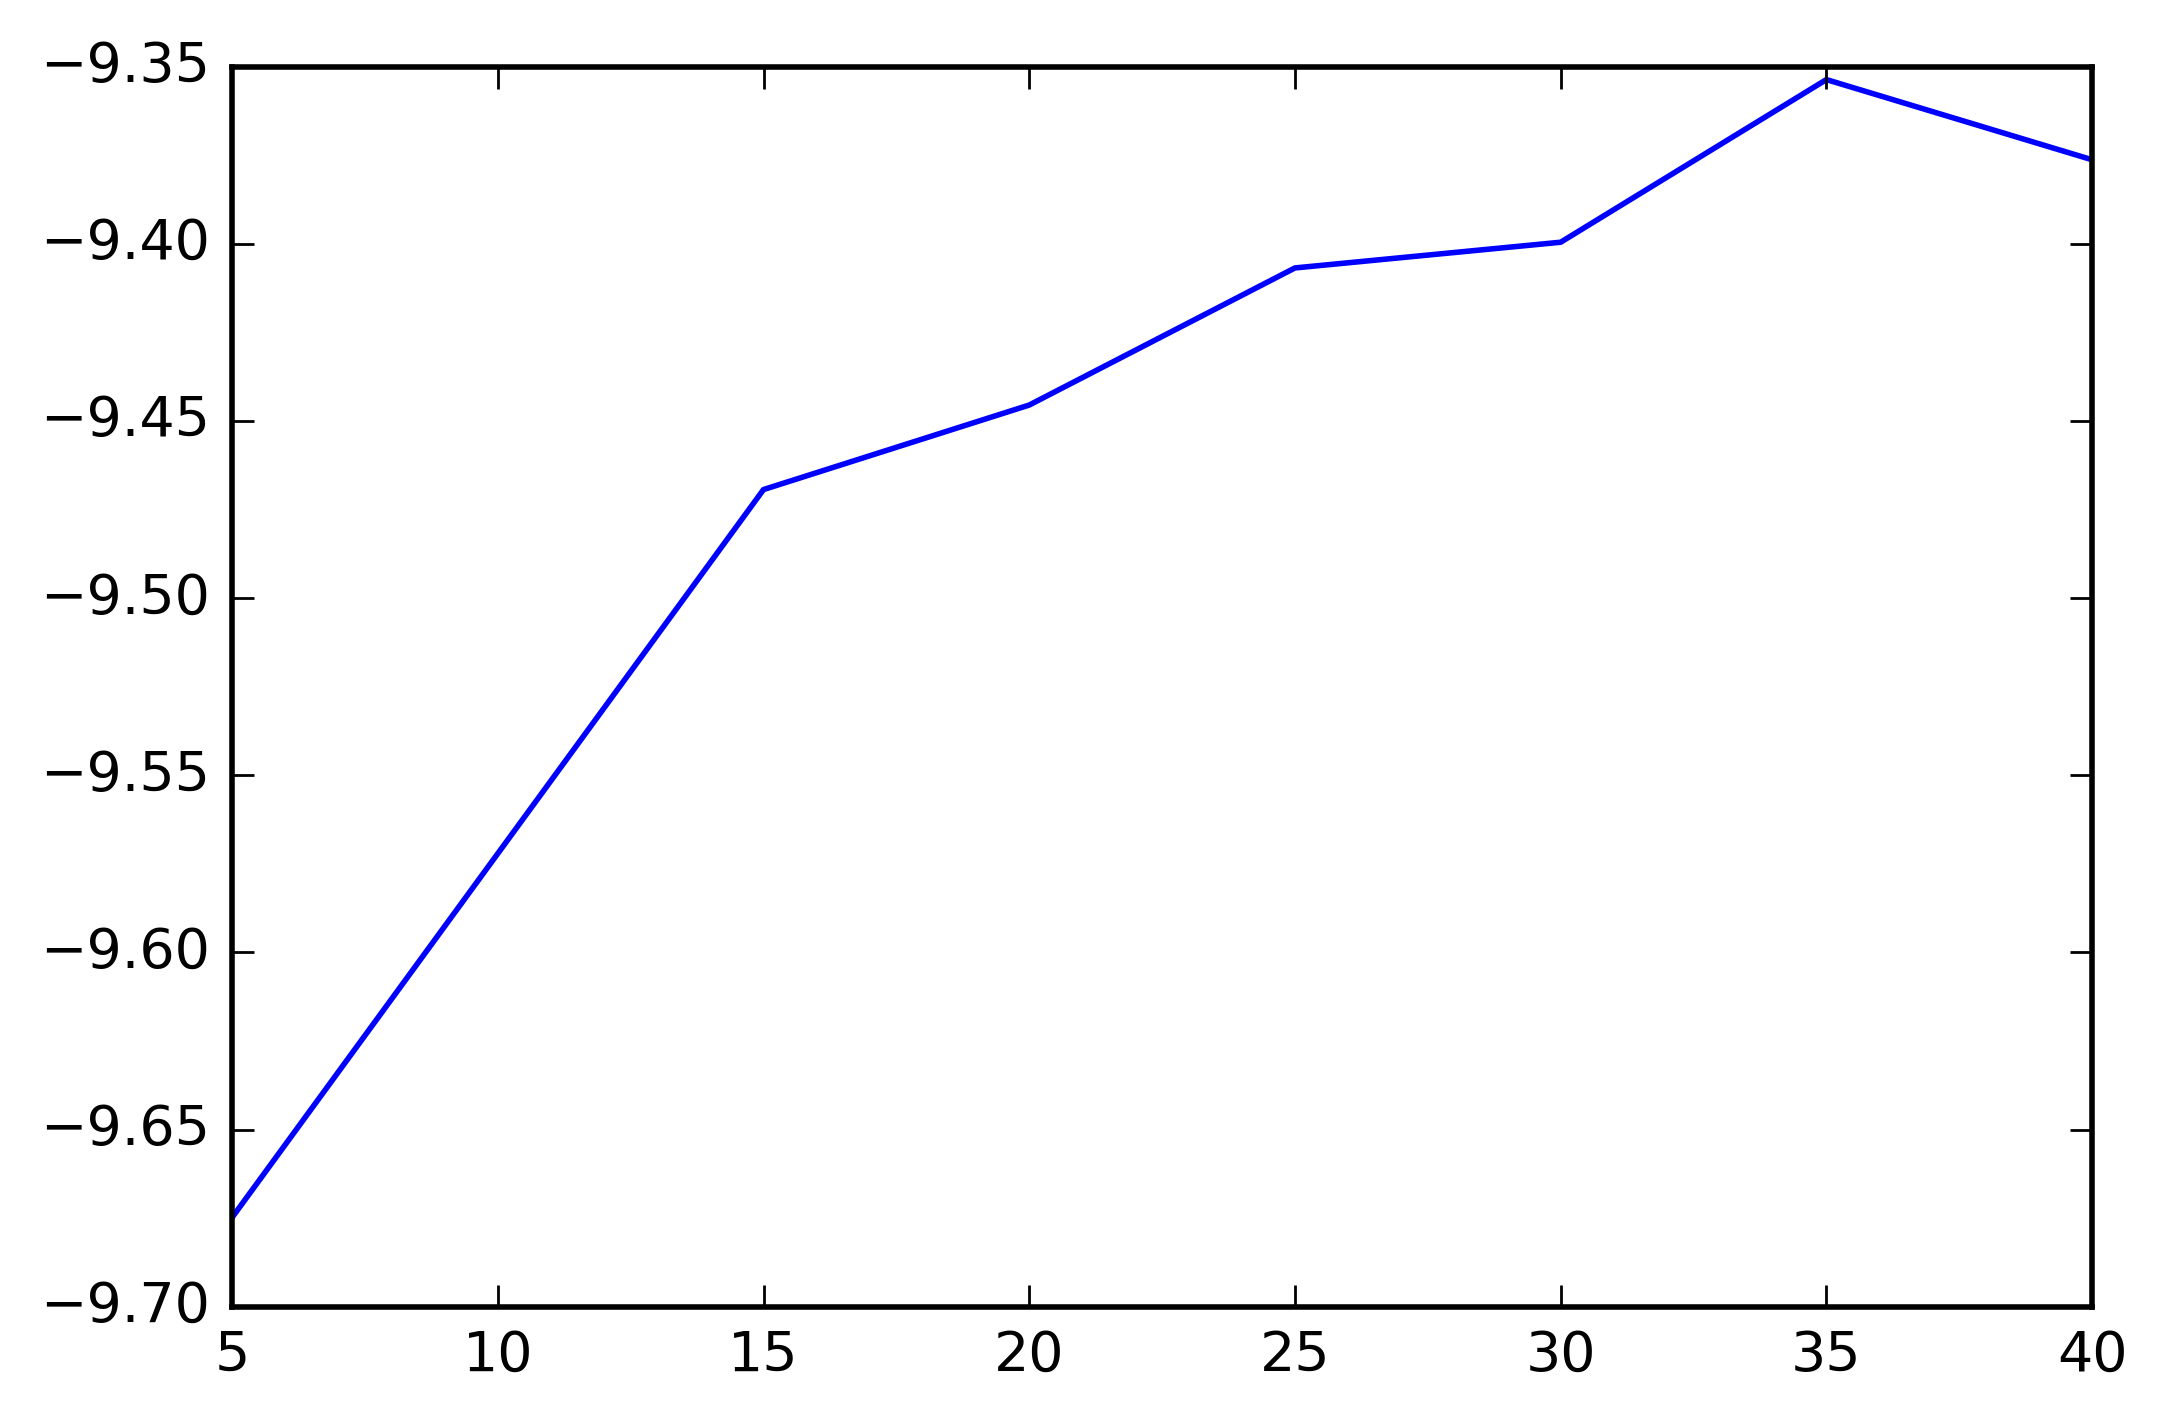

In [159]:
plt.plot([5, 15, 20, 25, 30, 35, 40], perplexity_list)

***
## 结论
使用LDA模型对主题的频率进行分析，使用TFIDF算法对抓取的文本进行处理，得出结果如图，当主题数在0-20之间时，权重波动较大，而当主题数大于20时，权重趋于平缓。

In [173]:
topictermlist = lda_model.print_topics(-1)
top_words = [[str(j).split('*')[1] for j in str(i).split(' + ')] for i in topictermlist] 
for j in top_words:
    top_w=[]
    for i in j:
        i=i.replace("')",'')
        i=i.decode('unicode_escape')
        top_w.append(i)
    print top_w

[u'\u5173\u6ce8', u'\u975e\u5e38', u'\u4f4e\u7a7a', u'\u5730\u9762', u'\u5413\u4eba', u'\u6761\u4ef6', u'\u63a7\u5236', u'\u53ef\u6015', u'\u5929\u6c14', u'\u540c\u610f']
[u'\u5317\u4eac', u'\u516c\u56ed', u'\u6cb3\u5317', u'\u5510\u5c71\u5e02', u'\u51e4\u51f0\u5c71', u'\u65f6\u4f59', u'\u5730\u70b9', u'46', u'\u4e0a\u5348', u'11']
[u'\u53e3\u7f69', u'\u8fc7\u6ee4', u'\u5fae\u7c73', u'\u600e\u4e48', u'\u51c0\u5316', u'\u9897\u7c92\u7269', u'\u578b\u53f7', u'\u76f4\u5f84', u'\u4ef7\u683c', u'\u9009\u62e9']
[u'\u5357\u65b9', u'\u533a\u57df', u'\u5927\u6c14\u6c61\u67d3', u'PM10', u'\u5730\u5e9c', u'RGF', u'\u7279\u4f9b', u'\u5927\u5bb6', u'\u597d\u4e8b', u'\u4e0d\u662f']
[u'09', u'11', u'\u505a\u8d77', u'2015', u'2013', u'\u79f8\u79c6', u'\u5927\u5bb6', u'14', u'18', u'08']
[u'\u7c73\u56fd', u'\u4e0d\u9519', u'\u5bb6\u91cc', u'\u4e00\u4f1a', u'\u7a7a\u6c14', u'\u591a\u5c11', u'\u6cbb\u6cbb', u'\u771f\u8be5', u'\u4e1c\u5317', u'\u8d44\u91cf']
[u'kazama2000', u'\u6307\u8d23', u'\u4ee5\u524d

In [178]:
for i in topictermlist:   
    y=str(i).split(' + ')
    for i in y:
        a=i.decode('unicode_escape')
        print a

(0, u'0.003*关注
0.002*非常
0.002*低空
0.002*地面
0.002*吓人
0.002*条件
0.002*控制
0.002*可怕
0.002*天气
0.002*同意')
(1, u'0.003*北京
0.002*公园
0.002*河北
0.002*唐山市
0.002*凤凰山
0.002*时余
0.002*地点
0.002*46
0.001*上午
0.001*11')
(2, u'0.003*口罩
0.002*过滤
0.002*微米
0.002*怎么
0.002*净化
0.002*颗粒物
0.002*型号
0.002*直径
0.001*价格
0.001*选择')
(3, u'0.002*南方
0.001*区域
0.001*大气污染
0.001*PM10
0.001*地府
0.001*RGF
0.001*特供
0.001*大家
0.001*好事
0.001*不是')
(4, u'0.007*09
0.006*11
0.004*做起
0.004*2015
0.004*2013
0.004*秸秆
0.004*大家
0.003*14
0.003*18
0.003*08')
(5, u'0.002*米国
0.002*不错
0.002*家里
0.001*一会
0.001*空气
0.001*多少
0.001*治治
0.001*真该
0.001*东北
0.001*资量')
(6, u'0.003*kazama2000
0.002*指责
0.002*以前
0.002*11
0.002*为什么
0.002*123
0.002*知道
0.001*台湾
0.001*北京市
0.001*供暖')
(7, u'0.003*出门
0.002*顶一下
0.002*对策
0.002*htm
0.002*地方
0.002*夺走
0.002*com
0.002*i36225874966
0.002*taobao
0.002*室外')
(8, u'0.003*产业
0.002*防控
0.002*大气污染
0.002*企业
0.002*环保
0.001*支持
0.001*学会
0.001*链接
0.001*打不开
0.001*青菜')
(9, u'0.002*广告
0.002*特供
0.002*别墅
0.002*领导
0.002*上海
0.002*几层楼
0.002*炫富
0.001

***
## 结论
通过文本处理，共取出20个主题，总计200种概念；第4组，9组，13组，19组，主题权重整体较高，分别概括为：PM2.5新闻（4组）；政治（9组）；环境（19组）可以得知，天涯论坛关于PM2.5的回帖中主要集中于PM2.5新闻数据报道的关注，政府和PM2.5相关性的讨论，以及PM2.5对环境产生影响的讨论。

In [190]:
x=[]
j=[(0, '0.003', '0.002', '0.002', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(1, '0.005', '0.005', '0.003', '0.003', '0.003', '0.003', '0.003', '0.003', '0.002', '0.002'),(2, '0.003', '0.002', '0.002', '0.002', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(3, '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.001', '0.001', '0.001', '0.001'),(4, '0.006', '0.006', '0.006', '0.005', '0.005', '0.004', '0.004', '0.004', '0.003', '0.003'),(5, '0.002', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(6, '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(7, '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.001', '0.001', '0.001'),(8, '0.003', '0.003', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002'),(9, '0.002', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(10, '0.024', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(11, '0.002', '0.002', '0.002', '0.002', '0.002', '0.001', '0.001', '0.001', '0.001', '0.001'),(12, '0.002', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(13, '0.003', '0.003', '0.003', '0.003', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002'),(14, '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(15, '0.002', '0.002', '0.002', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(16, '0.004', '0.003', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002'),(17, '0.003', '0.003', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002'),(18, '0.002', '0.002', '0.002', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001'),(19, '0.003', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002', '0.002')]
for i in j:
    top_words_shares = map(float, i)
    x.append(top_words_shares)
    top_words_shares=x
print top_words_shares

[[0.0, 0.003, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], [1.0, 0.005, 0.005, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002], [2.0, 0.003, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], [3.0, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001], [4.0, 0.006, 0.006, 0.006, 0.005, 0.005, 0.004, 0.004, 0.004, 0.003, 0.003], [5.0, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], [6.0, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], [7.0, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001], [8.0, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002], [9.0, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], [10.0, 0.024, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], [11.0, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001], [12.0, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0

In [192]:
def weightvalue(x):
    return (x - np.min(top_words_shares))*40/(np.max(top_words_shares) -np.min(top_words_shares)) + 10
 
top_words_shares = [map(weightvalue, i) for i in top_words_shares]  

def plotTopics(mintopics, maxtopics):
    num_top_words = 10
    plt.rcParams['figure.figsize'] = (10.0, 4.0)  
    n = 0
    for t in range(mintopics , maxtopics):
        plt.subplot(2, 15, n + 1)  # plot numbering starts with 1
        plt.ylim(0, num_top_words)  # stretch the y-axis to accommodate the words
        plt.xticks([])  # remove x-axis markings ('ticks')
        plt.yticks([]) # remove y-axis markings ('ticks')
        plt.title(u'主题 #{}'.format(t+1), size = 5)
        words = top_words[t][0:num_top_words ]
        words_shares = top_words_shares[t][0:num_top_words ]
        for i, (word, share) in enumerate(zip(words, words_shares)):
            plt.text(0.05, num_top_words-i-0.9, word, fontsize= np.log(share*15))
        n += 1

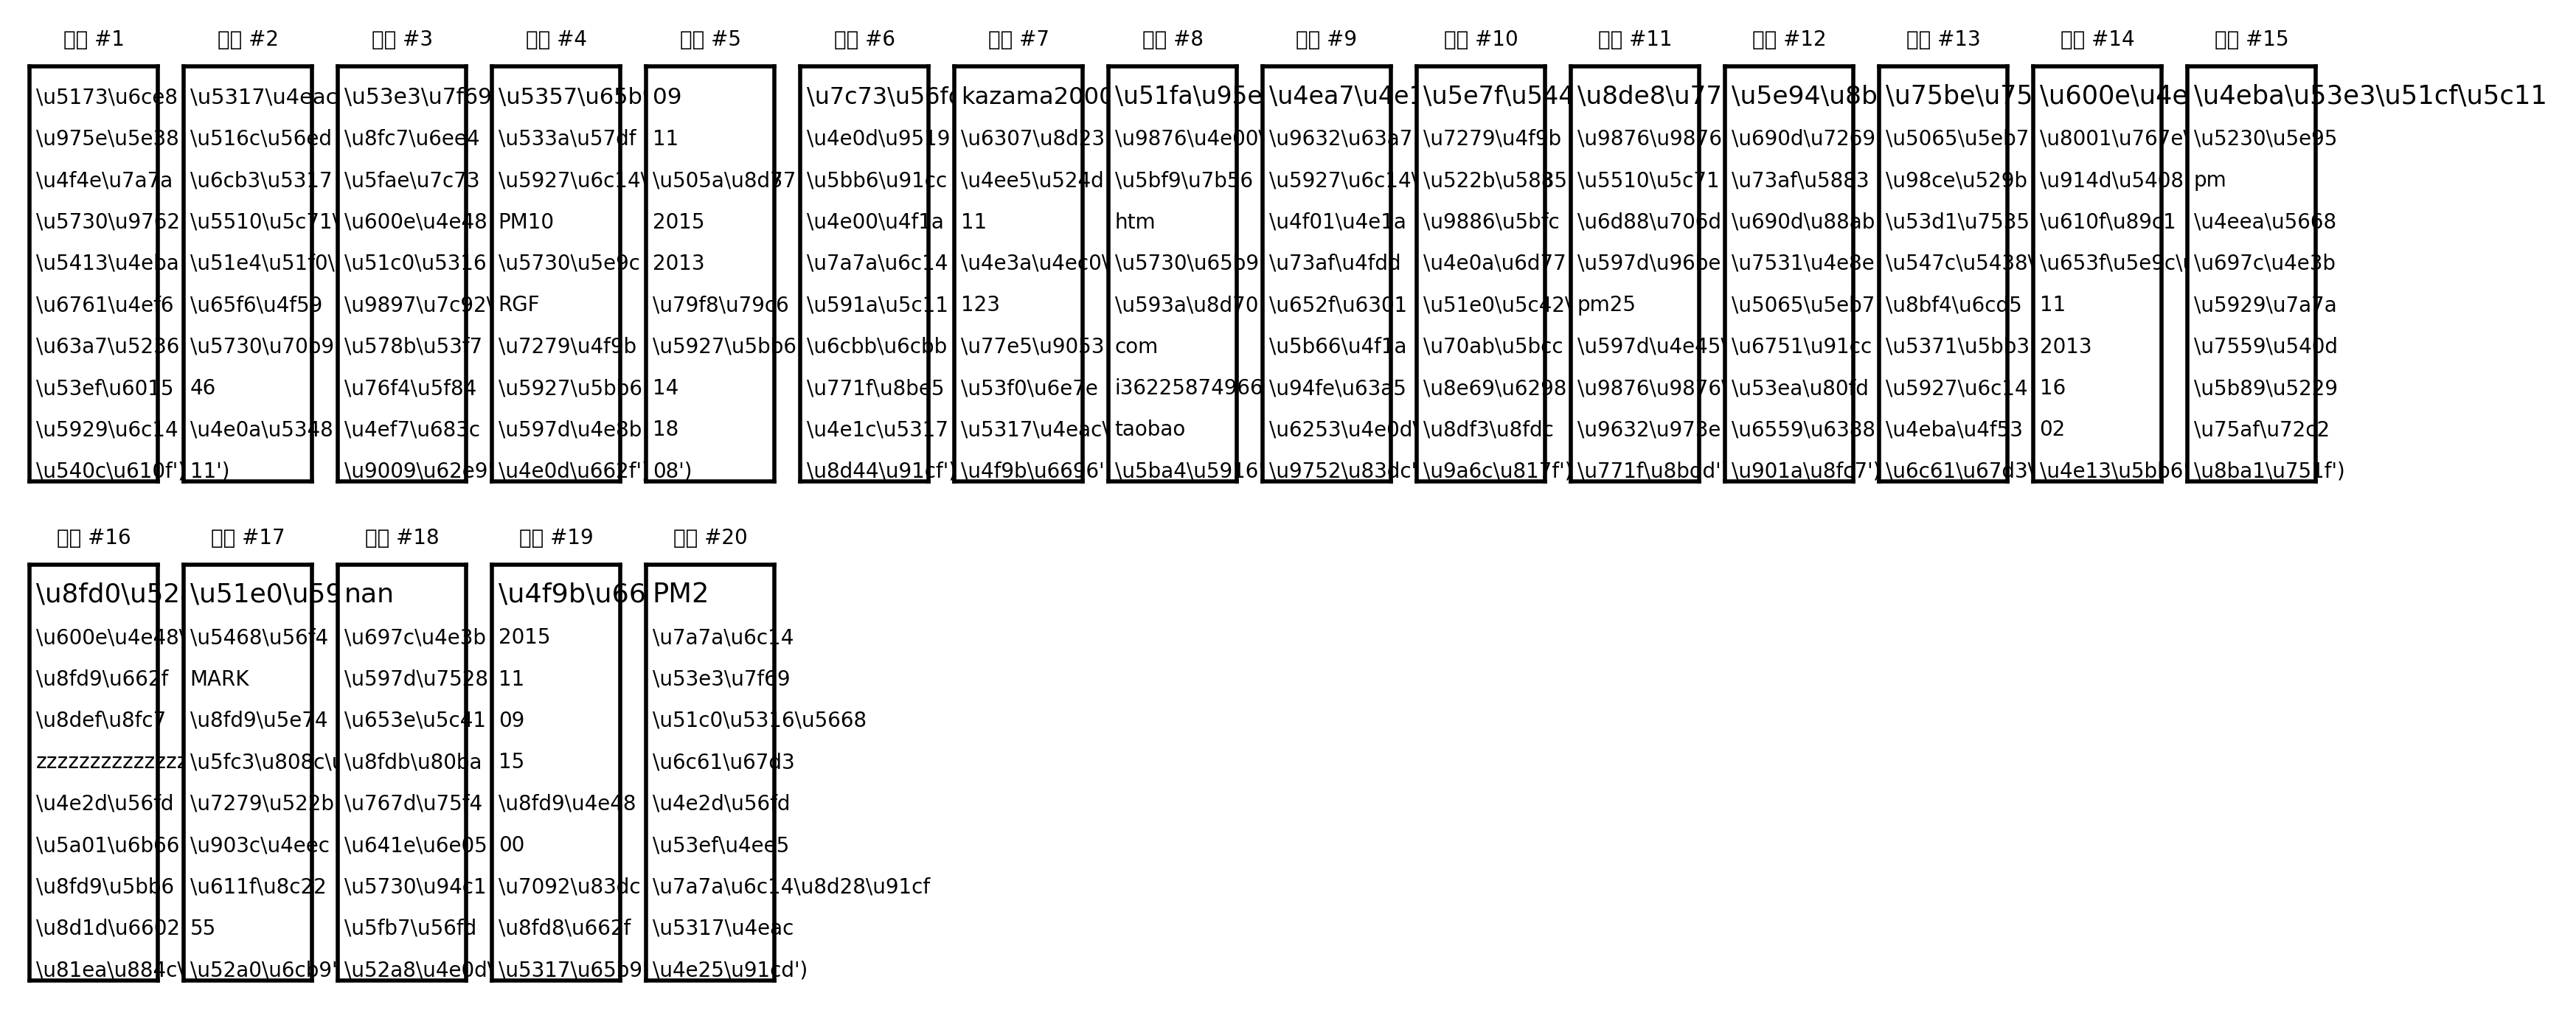

In [194]:
plotTopics(0, 20)

## 结论
主题的中文名重新编码总是失败，所以呈现出的文字是另一种格式的。